In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import netCDF4
import numpy as np
import typhon as ty

import konrad


ty.plots.styles.use()

# Clear-sky background

(100000.00000000001, 1000.0)

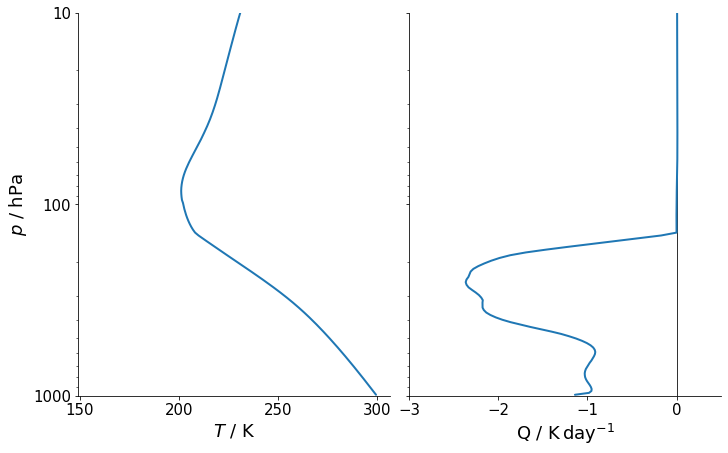

In [3]:
phlev = konrad.utils.get_quadratic_pgrid(num=256)
atmosphere = konrad.atmosphere.Atmosphere(phlev)

rrtmg = konrad.radiation.RRTMG()


rce = konrad.RCE(
    atmosphere=atmosphere,
    humidity=konrad.humidity.FixedRH(konrad.humidity.HeightConstant(0.8)),
    surface=konrad.surface.FixedTemperature(temperature=300.0),
    max_duration="100d",
    timestep="12h",
)
rce.run()

fig, (ax0, ax1) = plt.subplots(ncols=2, sharey=True)
ty.plots.profile_p_log(atmosphere["plev"], atmosphere["T"][-1], ax=ax0)
ax0.set_ylabel("$p$ / hPa")
ax0.set_xlabel("$T$ / K")

ax1.axvline(0, color="k", linewidth=0.8)
ty.plots.profile_p_log(atmosphere["plev"], rce.radiation["net_htngrt"][-1], ax=ax1)
ax1.set_xlabel("Q / $\sf K\,day^{-1}$")
ax1.set_xlim(-3, 0.5)
ax1.set_ylim(bottom=phlev.max(), top=10e2)

# Conceptual cloud

(100000.00000000001, 1000.0)

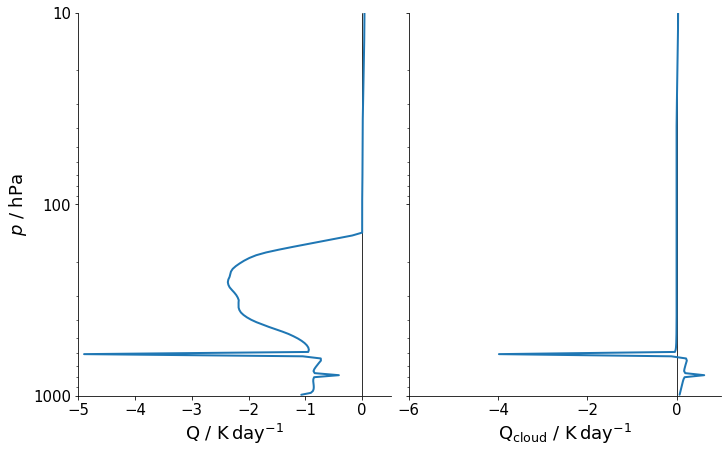

In [4]:
single_cloud = konrad.cloud.ConceptualCloud(
    atmosphere,  # required for consistent coordinates
    cloud_top=600e2,  # in Pa
    depth=200e2,  # in Pa
    phase="liquid",  # "ice" or "liquid"
    water_path=100.0,  # in g/m^3
    cloud_fraction=0.1,  # [0-1]
    particle_size=10,
)

rrtmg = konrad.radiation.RRTMG()
rrtmg.update_heatingrates(
    atmosphere=atmosphere,
    cloud=single_cloud,
)

fig, (ax0, ax1) = plt.subplots(ncols=2, sharey=True)
ax0.axvline(0, color="k", linewidth=0.8)
ty.plots.profile_p_log(atmosphere["plev"], rrtmg["net_htngrt"][-1], ax=ax0)
ax0.set_xlabel("Q / $\sf K\,day^{-1}$")
ax0.set_xlim(-5, 0.5)
ax0.set_ylabel("$p$ / hPa")
ax0.set_ylim(bottom=phlev.max())

ax1.axvline(0, color="k", linewidth=0.8)
ty.plots.profile_p_log(atmosphere["plev"], rrtmg["net_htngrt"][-1] - rrtmg["net_htngrt_clr"][-1], ax=ax1)
ax1.set_xlabel("$\sf Q_\mathrm{cloud}$ / $\sf K\,day^{-1}$")
ax1.set_xlim(-6, 1)
ax1.set_ylim(bottom=phlev.max(), top=10e2)

# Feedback

array([1.50297014, 1.50297014])

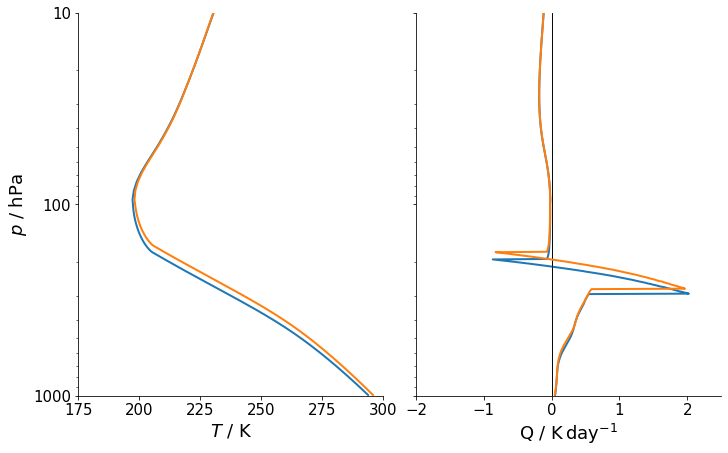

In [5]:
phlev = konrad.utils.get_quadratic_pgrid(num=2**8, top_pressure=10)

phlev = np.unique(
    np.concatenate(
        (
            ty.math.nlogspace(1000e2, 400e2, num=64 + 1),
            ty.math.nlogspace(400e2, 100e2, num=256 + 1),
            ty.math.nlogspace(100e2, 10, num=64),
        )
    )
)[::-1]

atmosphere = konrad.atmosphere.Atmosphere(phlev)

single_cloud = konrad.cloud.ConceptualCloud(
    atmosphere,  # required for consistent coordinates
    cloud_top=175e2,  # in Pa
    depth=100e2,  # in Pa
    phase="ice",  # "ice" or "liquid"
    water_path=24.0,  # in g/m^3
    cloud_fraction=0.3,  # [0-1]
    coupling="temperature:210",
    # coupling="subsidence_divergence",
)

fig, (ax0, ax1) = plt.subplots(ncols=2, sharey=True)
temperatures = [294.0, 296.0]
olr = []
for Ts in temperatures:
    rce = konrad.RCE(
        atmosphere=atmosphere,
        humidity=konrad.humidity.FixedRH(konrad.humidity.HeightConstant(0.8)),
        surface=konrad.surface.FixedTemperature(temperature=Ts),
        cloud=single_cloud,
        max_duration="150d",
        timestep="12h",
    )
    rce.run()

    olr.append(rce.radiation["lw_flxu"][-1, -1])
    
    ty.plots.profile_p_log(atmosphere["plev"], atmosphere["T"][-1], ax=ax0)
    ax0.set_ylabel("$p$ / hPa")
    ax0.set_xlabel("$T$ / K")
    ax0.set_xlim(175, 300)

    ax1.axvline(0, color="k", linewidth=0.8)
    ty.plots.profile_p_log(atmosphere["plev"], rce.radiation["net_htngrt"][-1] - rce.radiation["net_htngrt_clr"][-1], ax=ax1)
    ax1.set_xlabel("Q / $\sf K\,day^{-1}$")
    ax1.set_xlim(-2, 2.5)
    ax1.set_ylim(bottom=phlev.max(), top=10e2)
    
np.gradient(olr, temperatures)

# Cloud ensemble

In [6]:
p, ph = konrad.utils.get_pressure_grids(1000e2, 10, 256)
atmosphere = konrad.atmosphere.Atmosphere(ph)

rce = konrad.RCE(
    atmosphere,
    surface=konrad.surface.FixedTemperature(temperature=298.0),
    humidity=konrad.humidity.FixedRH(konrad.humidity.HeightConstant(0.75)),
    cloud=konrad.cloud.CloudEnsemble(
        konrad.cloud.ConceptualCloud(atmosphere, 175e2, 100e2, 0.15, coupling="subsidence_divergence"),
        konrad.cloud.ConceptualCloud(atmosphere, 500e2, 100e2, 0.15, coupling="temperature:255"),
        konrad.cloud.ConceptualCloud(atmosphere, 850e2, 100e2, 0.15, coupling="pressure"),
    ),
    max_duration="150d",
    timestep="12h",
    outfile="test-clouds.nc",
)
rce.run()

Text(0.5, 0, 'Simulated day')

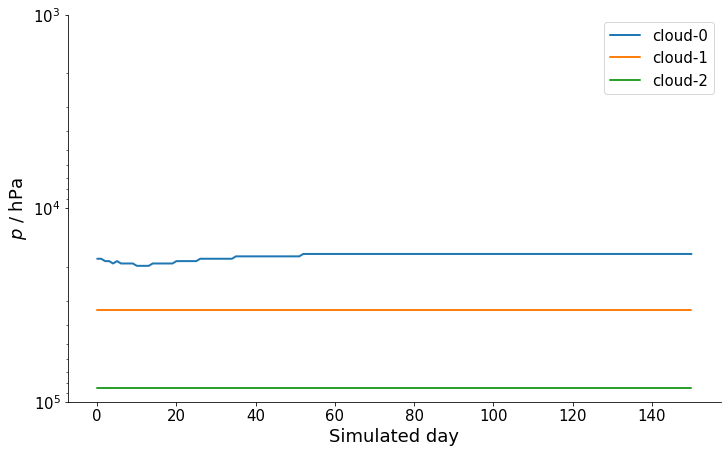

In [7]:
fig, ax = plt.subplots()
for key in ("cloud-0", "cloud-1", "cloud-2"):
    with netCDF4.Dataset("test-clouds.nc", "r") as root:
        time = root["time"][:] / 24
        cloud_top = root[f"cloud/{key}/cloud_top"][:]

    ax.plot(time, cloud_top, label=key)
ax.legend()
ax.set_yscale("log")
ax.set_ylim(1_000e2, 10e2)
ax.set_ylabel("$p$ / hPa")
ax.set_xlabel("Simulated day")